In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
print(pd.__version__)
train = pd.read_csv("/content/drive/My Drive/DA_Project/train.csv")
test = pd.read_csv("/content/drive/My Drive/DA_Project/test.csv")
print(train.shape)
print(test.shape)
#print(train)
#print(train.columns)
#train = train.append(test, ignore_index = True)
#train
train.groupby('sentiment').count()

1.0.3
(27486, 4)
(3535, 3)


,textID,text,selected_text
sentiment,,,
negative,7786,7786,7786
neutral,11118,11117,11117
positive,8582,8582,8582


[0.28327148366441096, 0.4044968347522375, 0.3122316815833515]
[0.28316831683168314, 0.4045261669024045, 0.3123055162659123]


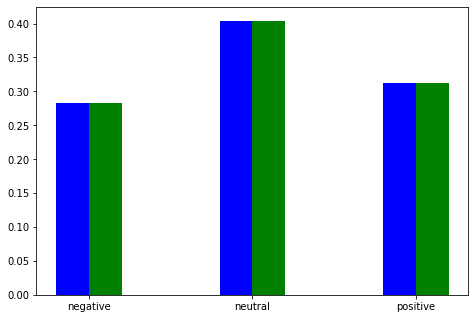

In [0]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
classes = ['negative', 'neutral', 'positive']
pos = np.arange(3)
counts = [(train.groupby('sentiment').count().to_numpy()[:,0]/27486).tolist(), (test.groupby('sentiment').count().to_numpy()[:,0]/3535).tolist()]

print(counts[0])
print(counts[1])

ax.set_xticks(pos)
ax.set_xticklabels(classes)
ax.bar(pos - 0.1, counts[0], color = 'b', width = 0.2)
ax.bar(pos + 0.1, counts[0], color = 'g', width = 0.2)
plt.show()

In [0]:
print(train[train['text'].isna()])

print(test[test['text'].isna()])

           textID text selected_text sentiment
13133  fdb77c3752  NaN           NaN   neutral
Empty DataFrame
Columns: [textID, text, sentiment]
Index: []


68.72288718303197
68.18755304101839


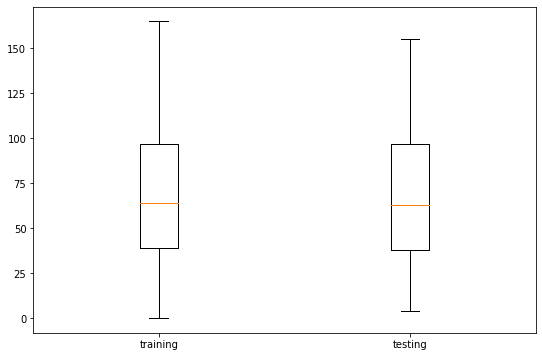

In [0]:
dlens = []
for i in train['text']:
  if pd.isna(i):
    dlens.append(0.0)
  dlens.append(len(str(i)))
  #print(i)
#print("average training set lenght")
#print(avg / 27486)

t_dlens = []
for i in test['text']:
  if pd.isna(i):
    t_dlens.append(0.0)
  t_dlens.append(len(str(i)))
  #print(i)
#print("average testing set lenght")
#print(avg / 3535)

arrs = [dlens, t_dlens]

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(arrs)
ax.set_xticklabels(["training", "testing"])

training_avg = sum(dlens)/len(dlens)
testing_avg = sum(t_dlens)/len(t_dlens)
print(training_avg)
print(testing_avg)

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27486 entries, 0 to 27485
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27486 non-null  object
 1   text           27485 non-null  object
 2   selected_text  27485 non-null  object
 3   sentiment      27486 non-null  object
dtypes: object(4)
memory usage: 859.1+ KB


**We have one null Value in the train , as the test field for value is NAN we will just remove it**

In [0]:
combi = train.append(test, ignore_index=True)
combi.dropna(inplace=True)

In [0]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3535 entries, 0 to 3534
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3535 non-null   object
 1   text       3535 non-null   object
 2   sentiment  3535 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [0]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt  

In [0]:
# remove twitter handles (@user)
combi['text'] = np.vectorize(remove_pattern)(combi['text'], "@[\w]*")

In [0]:
# remove special characters, numbers, punctuations
combi['text'] = combi['text'].str.replace("[^a-zA-Z#]", " ")
combi['text'] = combi['text'].str.replace("#bgt", " ")
combi['text'] = combi['text'].str.replace("#BGT", " ")
combi['text'] = combi['text'].str.replace("#FollowFriday", " ")
combi['text'] = combi['text'].str.replace("#followfriday", " ")
combi['text'] = combi['text'].str.replace("#hhrs", " ")

In [0]:
combi['text'] = combi['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [0]:
combi.head()

,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent entire morning meeting vendor boss happy...,my boss was not happy w/ them. Lots of fun.,neutral
1,251b6a6766,Good idea about putting them cream,Good,positive
2,c9e8d1ef1c,says good should afternoon http plurk wxpdj,says good (or should i say bad?) afternoon!,neutral
3,f14f087215,dont think vote anymore tried,i dont think you can vote anymore!,negative
4,bf7473b12d,haha better drunken tweeting mean,better,positive


In [0]:
tokenized = combi['text'].apply(lambda x: x.split())
tokenized.head()

0    [Spent, entire, morning, meeting, vendor, boss...
1            [Good, idea, about, putting, them, cream]
2    [says, good, should, afternoon, http, plurk, w...
3                  [dont, think, vote, anymore, tried]
4              [haha, better, drunken, tweeting, mean]
Name: text, dtype: object

In [0]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized = tokenized.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized.head()

0    [spent, entir, morn, meet, vendor, boss, happi...
1                [good, idea, about, put, them, cream]
2    [say, good, should, afternoon, http, plurk, wx...
3                     [dont, think, vote, anymor, tri]
4                 [haha, better, drunken, tweet, mean]
Name: text, dtype: object

In [0]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [0]:
# extracting hashtags from positive tweets
HT_negative = hashtag_extract(combi['text'][combi['sentiment'] == 'negative'])

# extracting hashtags from neutral tweets

HT_neutral = hashtag_extract(combi['text'][combi['sentiment'] == 'neutral'])

# extracting hashtags from positive tweets
HT_positive = hashtag_extract(combi['text'][combi['sentiment'] == 'positive'])

# unnesting list
HT_negative = sum(HT_negative,[])
HT_neutral = sum(HT_neutral,[])
HT_positive = sum(HT_positive,[])

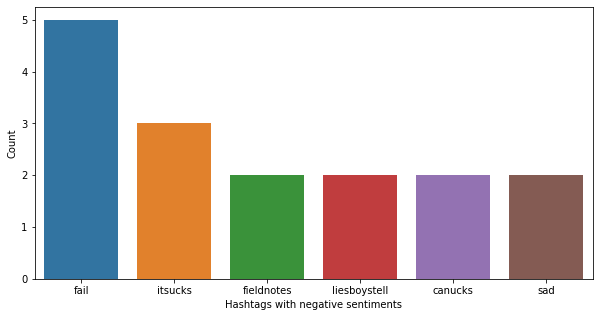

In [0]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtags with negative sentiments': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 6) 
plt.figure(figsize=(10,5))
ax = sns.barplot(data=d, x= "Hashtags with negative sentiments", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

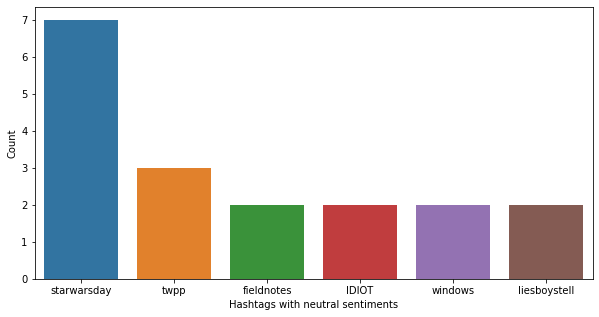

In [0]:
b = nltk.FreqDist(HT_neutral)
e = pd.DataFrame({'Hashtags with neutral sentiments': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 6)   
plt.figure(figsize=(10,5))
ax = sns.barplot(data=e, x= "Hashtags with neutral sentiments", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

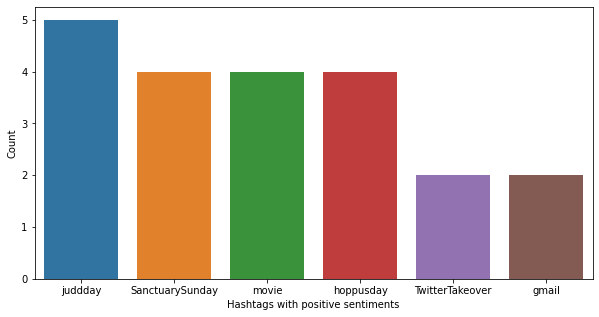

In [0]:
b = nltk.FreqDist(HT_positive)
e = pd.DataFrame({'Hashtags with positive sentiments': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 6)   
plt.figure(figsize=(10,5))
ax = sns.barplot(data=e, x= "Hashtags with positive sentiments", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

## **Exploratory train Extraction : EDA**

In [0]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [0]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

In [0]:
data = train.append(test, ignore_index=True)
data.head()

,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive


In [0]:
temp = data.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,12547
2,positive,9686
0,negative,8787


**A Funnel-Chart**

In [0]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
plt.figure(figsize=(18,9))
fig.show()

<Figure size 1296x648 with 0 Axes>

**WordClouds**
Understanding the common words used in the tweets: WordCloud
Now I want to see how well the given sentiments are distributed across the train dataset. One way to accomplish this task is by understanding the common words by plotting wordclouds.

A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

In [0]:
#cleaning data and converting sentiment to class labels

def getLower(x):
  #print(x)
  if pd.isna(x):
    return ''
  return x.lower()   #lowercased

data = data.astype('string')
data['sentiment'] = data['sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1})
data['text'] = data['text'].map(getLower)
data['text'] = data['text'].str.replace('[^\w\s]', '') #removing characters #Removing Punctuations, Numbers, and Special Characters
data

,textID,text,selected_text,sentiment
0,a3d0a7d5ad,spent the entire morning in a meeting w a vend...,my boss was not happy w/ them. Lots of fun.,0
1,251b6a6766,oh good idea about putting them on ice cream,Good,1
2,c9e8d1ef1c,says good or should i say bad afternoon httpp...,says good (or should i say bad?) afternoon!,0
3,f14f087215,i dont think you can vote anymore i tried,i dont think you can vote anymore!,-1
4,bf7473b12d,haha better drunken tweeting you mean,better,1
...,...,...,...,...
31016,2f8444db6c,_shannon1234 shannie im so sorry didnt mean to...,<NA>,-1
31017,11de8c0456,im slowing on my tweetscuase i lost my phone,<NA>,-1
31018,08f6036add,invasion of the old ladies has just ended stil...,<NA>,0
31019,27d6472b81,my nose stud fell out and i cant find it loo...,<NA>,-1


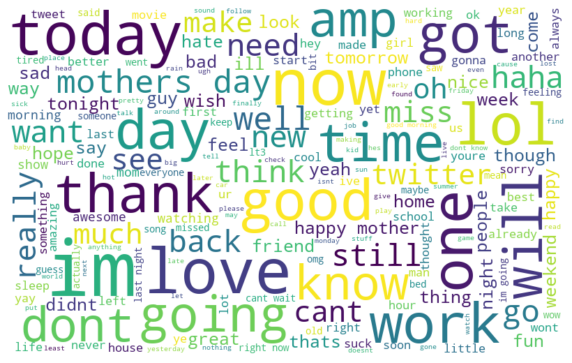

In [0]:
all_words = ' '.join([text for text in data['text']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500,background_color='white', random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**Words in neutral tweets**

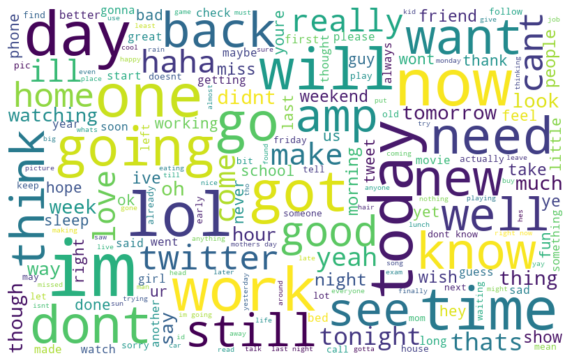

In [0]:
neutral_words =' '.join([text for text in data['text'][data['sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, background_color='white', random_state=21, max_font_size=110).generate(neutral_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**Words in negative tweets**

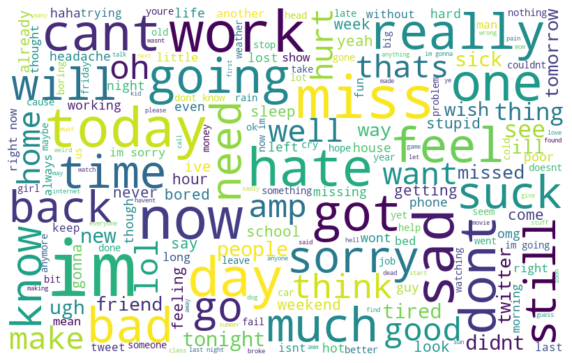

In [0]:
negative_words = ' '.join([text for text in data['text'][data['sentiment'] == -1]])
wordcloud = WordCloud(width=800, height=500,background_color='white',
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**Words in positive tweets**

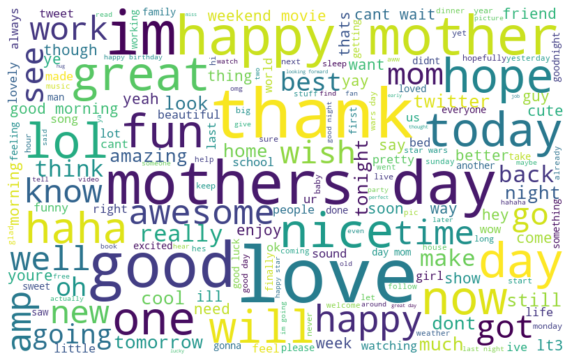

In [0]:
positive_words = ' '.join([text for text in data['text'][data['sentiment'] == 1]])
wordcloud = WordCloud(width=800, height=500,background_color='white',
random_state=21, max_font_size=110).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [0]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [0]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [0]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

AttributeError: ignored

In [0]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
data = data.merge(jaccard,how='outer')

In [0]:
data['Num_words_Selected_text'] = data['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
data['Num_word_text'] = data['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
data['difference_in_words'] = data['Num_word_text'] - data['Num_words_Selected_text'] #Difference in Number of words text and Selected Text

In [0]:
hist_data = [data['Num_words_Selected_text'],data['Num_word_text']]

group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

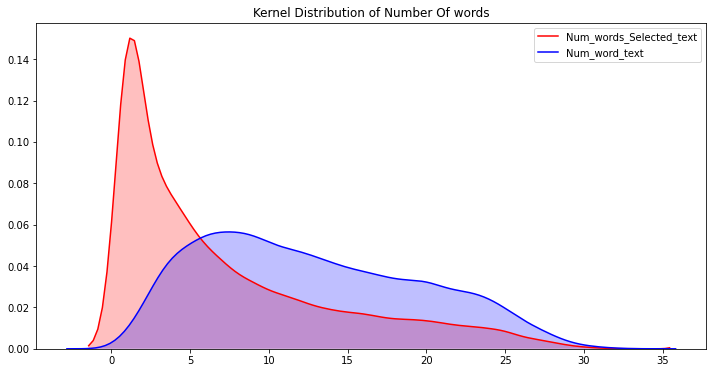

In [0]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(data['Num_words_Selected_text'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(data['Num_word_text'], shade=True, color="b")

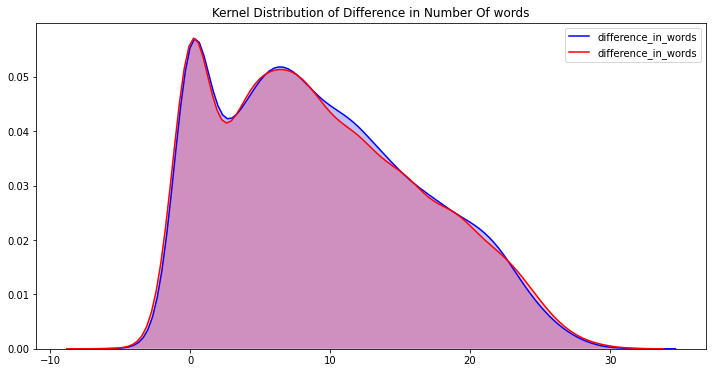

In [0]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(data[data['sentiment']==1]['difference_in_words'], shade=True, color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(data[data['sentiment']==-1]['difference_in_words'], shade=True, color="r")

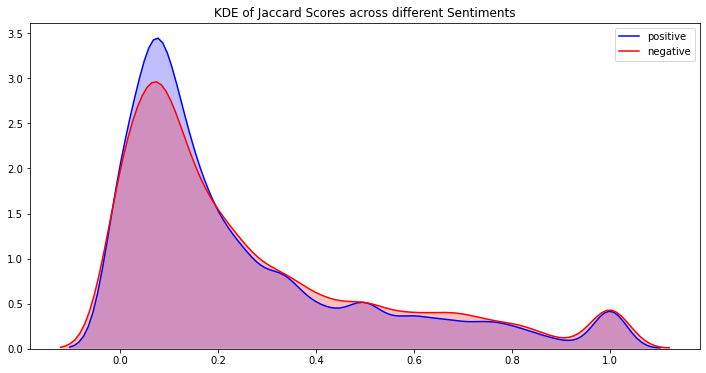

In [0]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(data[data['sentiment']==1]['jaccard_score'], shade=True, color="b").set_title('KDE of Jaccard Scores across different Sentiments')
p2=sns.kdeplot(data[data['sentiment']==-1]['jaccard_score'], shade=True, color="r")
plt.legend(labels=['positive','negative'])

In [0]:
k = data[data['Num_word_text']<=2]

In [0]:
k.groupby('sentiment').mean()['jaccard_score']

sentiment
-1    0.419228
 0    0.483719
 1    0.522357
Name: jaccard_score, dtype: float64

In [0]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [0]:
data['text'] = data['text'].apply(lambda x:clean_text(x))
data['selected_text'] = data['selected_text'].apply(lambda x:clean_text(x))

In [0]:
data['temp_list'] = data['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in data['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,i,7187
1,to,5306
2,the,4583
3,a,3542
4,my,2771
5,you,2605
6,and,2332
7,it,2144
8,is,2120
9,in,1979


In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
   def remove_stopword(x):
      return [y for y in x if y not in stopwords.words('english')]
data['temp_list'] = data['temp_list'].apply(lambda x:remove_stopword(x))

In [0]:
top = Counter([item for sublist in data['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,good,1237
2,day,1041
3,love,890
4,happy,843
5,like,772
6,get,770
7,dont,762
8,go,696
9,cant,611
10,work,604


In [0]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [0]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

TypeError: ignored